# RFM-анализ пользователей интернет-магазина

Необходимо провести RFM анализ, в каждом подсегменте поделить пользователей на 4 класса.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns

In [19]:
orders = pd.read_csv('RFM_ht_data.csv', low_memory=False)

In [20]:
orders.dtypes

InvoiceNo        object
CustomerCode     object
InvoiceDate      object
Amount          float64
dtype: object

In [21]:
orders.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [22]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [23]:
# приводим данные в нужный формат
orders['InvoiceNo'] = orders['InvoiceNo'].apply(str)
orders['CustomerCode'] = orders['CustomerCode'].apply(str)
orders['InvoiceDate'] = pd.to_datetime(orders['InvoiceDate'])

In [24]:
orders['InvoiceDate'].describe(datetime_is_numeric=True)

count                           332730
mean     2020-09-15 16:35:03.846361856
min                2020-09-01 00:00:00
25%                2020-09-08 00:00:00
50%                2020-09-16 00:00:00
75%                2020-09-24 00:00:00
max                2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

 Отсчитаем количество дней, прошедших с момента последней покупки, с максимальной даты покупки в датасете.

In [25]:
# дата последней покупки
last_date = orders['InvoiceDate'].max()
last_date

Timestamp('2020-09-30 00:00:00')

In [26]:
rfmTable = orders.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),      # Frequency #Количество заказов
                                        'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'Recency', 
                         'InvoiceNo': 'Frequency', 
                         'Amount': 'Monetary_Value'}, inplace=True)

In [27]:
rfmTable.head()

,Recency,Frequency,Monetary_Value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88


In [28]:
quantiles = rfmTable.quantile(q = [0.25, 0.5, 0.75])

In [29]:
# пограничные значения, попадая в которые пользователю будет присв. определен. класс для каждой из колонки 
quantiles

,Recency,Frequency,Monetary_Value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [30]:
rfmSegmentation = rfmTable

In [31]:
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1


In [32]:
# преобразование чтсловых значений в категориальные
rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RClass, args=('Recency',quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['Frequency'].apply(FMClass, args=('Frequency',quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['Monetary_Value'].apply(FMClass, args=('Monetary_Value',quantiles))

rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [33]:
rfmSegmentation

,Recency,Frequency,Monetary_Value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


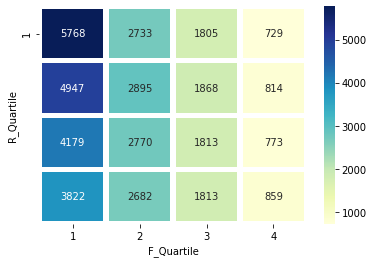

In [34]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='Monetary_Value', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

### Какое максимальное кол-во покупок было совершено одним пользователем?

In [35]:
orders['CustomerCode'].value_counts()[0]

204

### Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М?

Верхняя граница суммы покупок у пользователей с классом 4 в подсегменте М - 765

### Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?

Нижняя граница количества покупок у пользователей с классом 1 в подсегменте F - 4

### Сколько польователей попало в сегмент 111 (самые лояльные клиенты)

In [36]:
rfmSegmentation.query('RFMClass == "111"').shape[0]

9705

### Сколько польователей попало в сегмент 311

In [37]:
rfmSegmentation.query('RFMClass == "311"').shape[0]

1609

### В каком RFM-сегменте самое большое кол-во пользователей?

In [38]:
rfmSegmentation.RFMClass.value_counts().head(1)

444    10624
Name: RFMClass, dtype: int64

### В каком RFM-сегменте самое маленькое кол-во пользователей?

In [39]:
rfmSegmentation.RFMClass.value_counts()\
                        .sort_values()\
                        .head(1)

414    2
Name: RFMClass, dtype: int64